# Combine, Deduplicate, and Clean Climate Headlines Data

This notebook combines all climate headlines CSV files from the data folder, removes duplicates, and performs comprehensive data cleaning to create a final consolidated dataset.

## Objectives:
1. Load all CSV files from the data/processed folder
2. Combine them into a single DataFrame
3. Remove duplicate entries based on multiple criteria
4. Clean and standardize the data
5. Handle missing values and data type issues
6. Save the final cleaned dataset
7. Provide analysis of the cleaning process

## 1. Import Required Libraries

In [10]:
# Core data processing
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import re
import json
from pathlib import Path

# Text processing and cleaning
import string
from urllib.parse import urlparse
import hashlib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Progress tracking
from tqdm import tqdm

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("📚 Libraries imported successfully!")
print(f"🕐 Current time: {datetime.now()}")

📚 Libraries imported successfully!
🕐 Current time: 2025-08-20 18:06:44.129180


## 2. Load CSV Files from Data Folder

In [11]:
# Define data folder path
data_folder = "../data/processed"
csv_pattern = os.path.join(data_folder, "climate_headlines_*.csv")

# Find all CSV files
csv_files = glob.glob(csv_pattern)

print("📁 FOUND CSV FILES:")
print("=" * 50)

if csv_files:
    for i, file_path in enumerate(csv_files, 1):
        file_name = os.path.basename(file_path)
        file_size = os.path.getsize(file_path)
        
        # Get basic file info
        try:
            df_temp = pd.read_csv(file_path)
            row_count = len(df_temp)
            print(f"{i}. {file_name}")
            print(f"   📊 Rows: {row_count:,}")
            print(f"   💾 Size: {file_size/1024:.1f} KB")
            print(f"   📅 Modified: {datetime.fromtimestamp(os.path.getmtime(file_path))}")
            print()
        except Exception as e:
            print(f"   ❌ Error reading file: {e}")
            
    print(f"📈 Total files found: {len(csv_files)}")
else:
    print("❌ No CSV files found in the data folder!")
    print(f"   Searched in: {os.path.abspath(data_folder)}")

📁 FOUND CSV FILES:
1. climate_headlines_20250820_171702.csv
   📊 Rows: 57
   💾 Size: 29.0 KB
   📅 Modified: 2025-08-20 17:17:02.762495

2. climate_headlines_20250820_173904.csv
   📊 Rows: 322
   💾 Size: 224.6 KB
   📅 Modified: 2025-08-20 17:39:04.282259

3. climate_headlines_20250820_175121.csv
   📊 Rows: 520
   💾 Size: 338.5 KB
   📅 Modified: 2025-08-20 17:51:21.761632

4. climate_headlines_20250820_180549.csv
   📊 Rows: 524
   💾 Size: 341.6 KB
   📅 Modified: 2025-08-20 18:05:49.562968

5. climate_headlines_combined_clean_20250820_175711.csv
   📊 Rows: 440
   💾 Size: 318.1 KB
   📅 Modified: 2025-08-20 17:57:11.261014

📈 Total files found: 5


## 3. Combine All CSV Files

In [12]:
if csv_files:
    print("🔄 COMBINING CSV FILES...")
    print("=" * 40)
    
    combined_dataframes = []
    total_rows_before = 0
    file_sources = {}
    
    for file_path in tqdm(csv_files, desc="Loading files"):
        try:
            # Load CSV file
            df = pd.read_csv(file_path)
            
            # Add source file information
            file_name = os.path.basename(file_path)
            df['source_file'] = file_name
            
            # Extract timestamp from filename
            timestamp_match = re.search(r'(\d{8}_\d{6})', file_name)
            if timestamp_match:
                timestamp_str = timestamp_match.group(1)
                df['file_timestamp'] = pd.to_datetime(timestamp_str, format='%Y%m%d_%H%M%S')
            else:
                df['file_timestamp'] = pd.NaT
            
            combined_dataframes.append(df)
            file_sources[file_name] = len(df)
            total_rows_before += len(df)
            
            print(f"✅ Loaded {file_name}: {len(df):,} rows")
            
        except Exception as e:
            print(f"❌ Error loading {file_path}: {e}")
    
    if combined_dataframes:
        # Combine all DataFrames
        df_combined = pd.concat(combined_dataframes, ignore_index=True)
        
        print("\n📊 COMBINATION RESULTS:")
        print("=" * 40)
        print(f"Total rows before combination: {total_rows_before:,}")
        print(f"Combined DataFrame rows: {len(df_combined):,}")
        print(f"Columns: {len(df_combined.columns)}")
        
        print("\n📁 Rows per source file:")
        for file_name, count in file_sources.items():
            percentage = count / total_rows_before * 100
            print(f"  {file_name}: {count:,} ({percentage:.1f}%)")
        
        # Display combined DataFrame info
        print("\n📋 Combined DataFrame Info:")
        print(df_combined.info())
        
    else:
        print("❌ No data was successfully loaded!")
        df_combined = pd.DataFrame()

else:
    print("❌ No CSV files to combine!")
    df_combined = pd.DataFrame()

🔄 COMBINING CSV FILES...


Loading files:   0%|          | 0/5 [00:00<?, ?it/s]

✅ Loaded climate_headlines_20250820_171702.csv: 57 rows
✅ Loaded climate_headlines_20250820_173904.csv: 322 rows
✅ Loaded climate_headlines_20250820_175121.csv: 520 rows


Loading files: 100%|██████████| 5/5 [00:00<00:00, 54.98it/s]

✅ Loaded climate_headlines_20250820_180549.csv: 524 rows
✅ Loaded climate_headlines_combined_clean_20250820_175711.csv: 440 rows

📊 COMBINATION RESULTS:
Total rows before combination: 1,863
Combined DataFrame rows: 1,863
Columns: 15

📁 Rows per source file:
  climate_headlines_20250820_171702.csv: 57 (3.1%)
  climate_headlines_20250820_173904.csv: 322 (17.3%)
  climate_headlines_20250820_175121.csv: 520 (27.9%)
  climate_headlines_20250820_180549.csv: 524 (28.1%)
  climate_headlines_combined_clean_20250820_175711.csv: 440 (23.6%)

📋 Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863 entries, 0 to 1862
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   title               1863 non-null   object        
 1   summary             1829 non-null   object        
 2   source              1863 non-null   object        
 3   url                 1863 non-null   object  

## 4. Remove Duplicate Rows

In [13]:
if not df_combined.empty:
    print("🔍 DUPLICATE DETECTION AND REMOVAL")
    print("=" * 50)
    
    initial_count = len(df_combined)
    print(f"Initial row count: {initial_count:,}")
    
    # Check for exact duplicates (all columns)
    exact_duplicates = df_combined.duplicated().sum()
    print(f"Exact duplicates (all columns): {exact_duplicates:,}")
    
    # Check for duplicates based on title + source
    title_source_duplicates = df_combined.duplicated(subset=['title', 'source']).sum()
    print(f"Title + Source duplicates: {title_source_duplicates:,}")
    
    # Check for duplicates based on URL
    url_duplicates = df_combined.duplicated(subset=['url']).sum()
    print(f"URL duplicates: {url_duplicates:,}")
    
    # Check for duplicates based on title only (potential near-duplicates)
    title_duplicates = df_combined.duplicated(subset=['title']).sum()
    print(f"Title-only duplicates: {title_duplicates:,}")
    
    print("\n🧹 REMOVING DUPLICATES...")
    
    # Step 1: Remove exact duplicates
    df_no_exact_dups = df_combined.drop_duplicates()
    print(f"After removing exact duplicates: {len(df_no_exact_dups):,} rows ({initial_count - len(df_no_exact_dups):,} removed)")
    
    # Step 2: Remove URL duplicates (keep the most recent)
    df_no_url_dups = df_no_exact_dups.sort_values('collected_date', ascending=False).drop_duplicates(subset=['url'], keep='first')
    print(f"After removing URL duplicates: {len(df_no_url_dups):,} rows ({len(df_no_exact_dups) - len(df_no_url_dups):,} removed)")
    
    # Step 3: Handle title + source duplicates (keep the most recent)
    df_no_title_source_dups = df_no_url_dups.sort_values('collected_date', ascending=False).drop_duplicates(subset=['title', 'source'], keep='first')
    print(f"After removing title+source duplicates: {len(df_no_title_source_dups):,} rows ({len(df_no_url_dups) - len(df_no_title_source_dups):,} removed)")
    
    # Step 4: Identify potential near-duplicates (similar titles)
    print("\n🔍 ANALYZING POTENTIAL NEAR-DUPLICATES...")
    
    # Create a normalized title for better duplicate detection
    df_no_title_source_dups['title_normalized'] = df_no_title_source_dups['title'].str.lower().str.strip()
    df_no_title_source_dups['title_normalized'] = df_no_title_source_dups['title_normalized'].str.replace(r'[^\w\s]', '', regex=True)
    df_no_title_source_dups['title_normalized'] = df_no_title_source_dups['title_normalized'].str.replace(r'\s+', ' ', regex=True)
    
    # Remove duplicates based on normalized title
    df_cleaned = df_no_title_source_dups.sort_values('collected_date', ascending=False).drop_duplicates(subset=['title_normalized'], keep='first')
    print(f"After removing normalized title duplicates: {len(df_cleaned):,} rows ({len(df_no_title_source_dups) - len(df_cleaned):,} removed)")
    
    # Remove the temporary normalized column
    df_cleaned = df_cleaned.drop('title_normalized', axis=1)
    
    print("\n📊 DEDUPLICATION SUMMARY:")
    print("=" * 40)
    print(f"Original rows: {initial_count:,}")
    print(f"Final rows: {len(df_cleaned):,}")
    print(f"Total duplicates removed: {initial_count - len(df_cleaned):,} ({(initial_count - len(df_cleaned))/initial_count*100:.1f}%)")
    print(f"Data retention rate: {len(df_cleaned)/initial_count*100:.1f}%")
    
else:
    print("❌ No data to deduplicate!")
    df_cleaned = pd.DataFrame()

🔍 DUPLICATE DETECTION AND REMOVAL
Initial row count: 1,863
Exact duplicates (all columns): 1
Title + Source duplicates: 1,300
URL duplicates: 1,412
Title-only duplicates: 1,380

🧹 REMOVING DUPLICATES...
After removing exact duplicates: 1,862 rows (1 removed)
After removing URL duplicates: 451 rows (1,411 removed)
After removing title+source duplicates: 451 rows (0 removed)

🔍 ANALYZING POTENTIAL NEAR-DUPLICATES...
After removing normalized title duplicates: 448 rows (3 removed)

📊 DEDUPLICATION SUMMARY:
Original rows: 1,863
Final rows: 448
Total duplicates removed: 1,415 (76.0%)
Data retention rate: 24.0%


## 5. Handle Missing Values

In [14]:
if not df_cleaned.empty:
    print("🔍 MISSING VALUES ANALYSIS")
    print("=" * 40)
    
    # Check for missing values
    missing_info = df_cleaned.isnull().sum()
    missing_percentage = (df_cleaned.isnull().sum() / len(df_cleaned)) * 100
    
    missing_df = pd.DataFrame({
        'Column': missing_info.index,
        'Missing Count': missing_info.values,
        'Missing Percentage': missing_percentage.values
    }).sort_values('Missing Count', ascending=False)
    
    print("Missing values by column:")
    for _, row in missing_df.iterrows():
        if row['Missing Count'] > 0:
            print(f"  {row['Column']:20s}: {row['Missing Count']:4.0f} ({row['Missing Percentage']:5.1f}%)")
    
    if missing_df['Missing Count'].sum() == 0:
        print("✅ No missing values found!")
    
    print("\n🧹 CLEANING MISSING VALUES...")
    
    # Handle missing values based on column importance
    df_cleaned_mv = df_cleaned.copy()
    
    # 1. Remove rows with missing title (critical field)
    if df_cleaned_mv['title'].isnull().any():
        rows_before = len(df_cleaned_mv)
        df_cleaned_mv = df_cleaned_mv.dropna(subset=['title'])
        rows_removed = rows_before - len(df_cleaned_mv)
        print(f"Removed {rows_removed} rows with missing titles")
    
    # 2. Fill missing summaries with empty string
    if df_cleaned_mv['summary'].isnull().any():
        df_cleaned_mv['summary'] = df_cleaned_mv['summary'].fillna('')
        print("Filled missing summaries with empty strings")
    
    # 3. Handle missing dates
    if df_cleaned_mv['published_date'].isnull().any():
        missing_dates = df_cleaned_mv['published_date'].isnull().sum()
        print(f"Found {missing_dates} rows with missing published_date - keeping as NaT")
    
    # 4. Fill missing text length calculations
    if 'text_length' not in df_cleaned_mv.columns or df_cleaned_mv['text_length'].isnull().any():
        df_cleaned_mv['text_length'] = df_cleaned_mv['title'].str.len()
        print("Recalculated text_length from titles")
    
    if 'summary_length' not in df_cleaned_mv.columns or df_cleaned_mv['summary_length'].isnull().any():
        df_cleaned_mv['summary_length'] = df_cleaned_mv['summary'].str.len()
        print("Recalculated summary_length from summaries")
    
    if 'title_words' not in df_cleaned_mv.columns or df_cleaned_mv['title_words'].isnull().any():
        df_cleaned_mv['title_words'] = df_cleaned_mv['title'].str.split().str.len()
        print("Recalculated title_words from titles")
    
    if 'title_chars' not in df_cleaned_mv.columns or df_cleaned_mv['title_chars'].isnull().any():
        df_cleaned_mv['title_chars'] = df_cleaned_mv['title'].str.len()
        print("Recalculated title_chars from titles")
    
    print(f"\nRows after missing value handling: {len(df_cleaned_mv):,}")
    
else:
    print("❌ No data to clean!")
    df_cleaned_mv = pd.DataFrame()

🔍 MISSING VALUES ANALYSIS
Missing values by column:
  has_summary         :  443 ( 98.9%)
  title_quality       :  443 ( 98.9%)
  has_published_date  :  443 ( 98.9%)
  summary             :   10 (  2.2%)

🧹 CLEANING MISSING VALUES...
Filled missing summaries with empty strings

Rows after missing value handling: 448


## 6. Clean Data Types and Standardize

In [15]:
if not df_cleaned_mv.empty:
    print("🔧 DATA TYPE CLEANING AND STANDARDIZATION")
    print("=" * 50)
    
    df_final = df_cleaned_mv.copy()
    
    print("Original data types:")
    for col, dtype in df_final.dtypes.items():
        print(f"  {col:20s}: {dtype}")
    
    print("\n🔄 Converting data types...")
    
    # 1. Convert date columns
    date_columns = ['published_date', 'collected_date', 'file_timestamp']
    for col in date_columns:
        if col in df_final.columns:
            try:
                df_final[col] = pd.to_datetime(df_final[col], errors='coerce')
                print(f"✅ Converted {col} to datetime")
            except Exception as e:
                print(f"❌ Error converting {col}: {e}")
    
    # 2. Ensure numeric columns are proper integers
    numeric_columns = ['text_length', 'summary_length', 'title_words', 'title_chars']
    for col in numeric_columns:
        if col in df_final.columns:
            try:
                df_final[col] = pd.to_numeric(df_final[col], errors='coerce').fillna(0).astype(int)
                print(f"✅ Converted {col} to integer")
            except Exception as e:
                print(f"❌ Error converting {col}: {e}")
    
    # 3. Clean and standardize text fields
    print("\n🧹 Cleaning text fields...")
    
    # Clean titles
    if 'title' in df_final.columns:
        df_final['title'] = df_final['title'].astype(str).str.strip()
        df_final['title'] = df_final['title'].str.replace(r'\s+', ' ', regex=True)  # Multiple spaces to single
        print("✅ Cleaned title field")
    
    # Clean summaries  
    if 'summary' in df_final.columns:
        df_final['summary'] = df_final['summary'].astype(str).str.strip()
        df_final['summary'] = df_final['summary'].str.replace(r'\s+', ' ', regex=True)
        df_final['summary'] = df_final['summary'].replace('nan', '')  # Replace 'nan' strings
        print("✅ Cleaned summary field")
    
    # Clean source names
    if 'source' in df_final.columns:
        df_final['source'] = df_final['source'].astype(str).str.strip()
        print("✅ Cleaned source field")
    
    # 4. Validate and clean URLs
    if 'url' in df_final.columns:
        print("\n🔗 Validating URLs...")
        valid_urls = 0
        invalid_urls = 0
        
        for idx, url in df_final['url'].items():
            try:
                parsed = urlparse(str(url))
                if parsed.scheme and parsed.netloc:
                    valid_urls += 1
                else:
                    invalid_urls += 1
            except:
                invalid_urls += 1
        
        print(f"Valid URLs: {valid_urls:,}")
        print(f"Invalid URLs: {invalid_urls:,}")
    
    # 5. Add data quality flags
    df_final['has_summary'] = (df_final['summary'].str.len() > 0) & (df_final['summary'] != 'nan')
    df_final['has_published_date'] = df_final['published_date'].notna()
    df_final['title_quality'] = df_final['title_words'].apply(lambda x: 'high' if x >= 5 else 'medium' if x >= 3 else 'low')
    
    print("\n📊 Data quality metrics added:")
    print(f"  Headlines with summaries: {df_final['has_summary'].sum():,} ({df_final['has_summary'].mean()*100:.1f}%)")
    print(f"  Headlines with dates: {df_final['has_published_date'].sum():,} ({df_final['has_published_date'].mean()*100:.1f}%)")
    print(f"  High quality titles: {(df_final['title_quality'] == 'high').sum():,} ({(df_final['title_quality'] == 'high').mean()*100:.1f}%)")
    
    print("\n✅ Final data types:")
    for col, dtype in df_final.dtypes.items():
        print(f"  {col:20s}: {dtype}")
    
    print(f"\nFinal dataset shape: {df_final.shape}")
    
else:
    print("❌ No data to clean!")
    df_final = pd.DataFrame()

🔧 DATA TYPE CLEANING AND STANDARDIZATION
Original data types:
  title               : object
  summary             : object
  source              : object
  url                 : object
  published_date      : object
  collected_date      : object
  text_length         : int64
  summary_length      : int64
  title_words         : int64
  title_chars         : int64
  source_file         : object
  file_timestamp      : datetime64[ns]
  has_summary         : object
  has_published_date  : object
  title_quality       : object

🔄 Converting data types...
✅ Converted published_date to datetime
✅ Converted collected_date to datetime
✅ Converted file_timestamp to datetime
✅ Converted text_length to integer
✅ Converted summary_length to integer
✅ Converted title_words to integer
✅ Converted title_chars to integer

🧹 Cleaning text fields...
✅ Cleaned title field
✅ Cleaned summary field
✅ Cleaned source field

🔗 Validating URLs...
Valid URLs: 448
Invalid URLs: 0

📊 Data quality metrics added:


## 7. Data Analysis and Quality Assessment

In [16]:
if not df_final.empty:
    print("📊 FINAL DATASET ANALYSIS")
    print("=" * 50)
    
    # Basic statistics
    print(f"📈 Total headlines: {len(df_final):,}")
    print(f"📰 Unique sources: {df_final['source'].nunique()}")
    print(f"🔗 Unique URLs: {df_final['url'].nunique()}")
    
    # Date range
    if df_final['published_date'].notna().any():
        date_min = df_final['published_date'].min()
        date_max = df_final['published_date'].max()
        date_range = (date_max - date_min).days if pd.notna(date_min) and pd.notna(date_max) else 0
        print(f"📅 Date range: {date_min} to {date_max} ({date_range} days)")
    
    # Text statistics
    print(f"📝 Average title length: {df_final['title_chars'].mean():.1f} characters")
    print(f"📝 Average title words: {df_final['title_words'].mean():.1f} words")
    print(f"📝 Average summary length: {df_final['summary_length'].mean():.1f} characters")
    
    # Source distribution
    print("\n📰 Top 10 sources by headline count:")
    source_counts = df_final['source'].value_counts().head(10)
    for source, count in source_counts.items():
        percentage = count / len(df_final) * 100
        print(f"  {source:25s}: {count:4d} ({percentage:5.1f}%)")
    
    # Quality distribution
    print(f"\n🏆 Quality distribution:")
    quality_counts = df_final['title_quality'].value_counts()
    for quality, count in quality_counts.items():
        percentage = count / len(df_final) * 100
        print(f"  {quality:10s}: {count:4d} ({percentage:5.1f}%)")
    
    # File source distribution
    if 'source_file' in df_final.columns:
        print("\n📁 Headlines by source file:")
        file_counts = df_final['source_file'].value_counts()
        for file_name, count in file_counts.items():
            percentage = count / len(df_final) * 100
            print(f"  {file_name:30s}: {count:4d} ({percentage:5.1f}%)")

else:
    print("❌ No data to analyze!")

📊 FINAL DATASET ANALYSIS
📈 Total headlines: 448
📰 Unique sources: 39
🔗 Unique URLs: 448
📅 Date range: 2021-03-05 12:47:55 to 2025-08-20 16:02:58 (1629 days)
📝 Average title length: 74.8 characters
📝 Average title words: 11.6 words
📝 Average summary length: 357.6 characters

📰 Top 10 sources by headline count:
  Google_News_Global_Warming:   65 ( 14.5%)
  Google_News_Climate_Change:   49 ( 10.9%)
  LA_Times_Environment     :   30 (  6.7%)
  Science_Daily_Earth_Climate:   30 (  6.7%)
  France24_Environment     :   26 (  5.8%)
  NYTimes_Climate          :   26 (  5.8%)
  Science_Daily_Environment:   20 (  4.5%)
  Climate_Home_News        :   17 (  3.8%)
  Solar_Power_World        :   16 (  3.6%)
  Phys_Org_Environment_Specific:   16 (  3.6%)

🏆 Quality distribution:
  high      :  445 ( 99.3%)
  medium    :    3 (  0.7%)

📁 Headlines by source file:
  climate_headlines_20250820_180549.csv:  440 ( 98.2%)
  climate_headlines_combined_clean_20250820_175711.csv:    5 (  1.1%)
  climate_headli

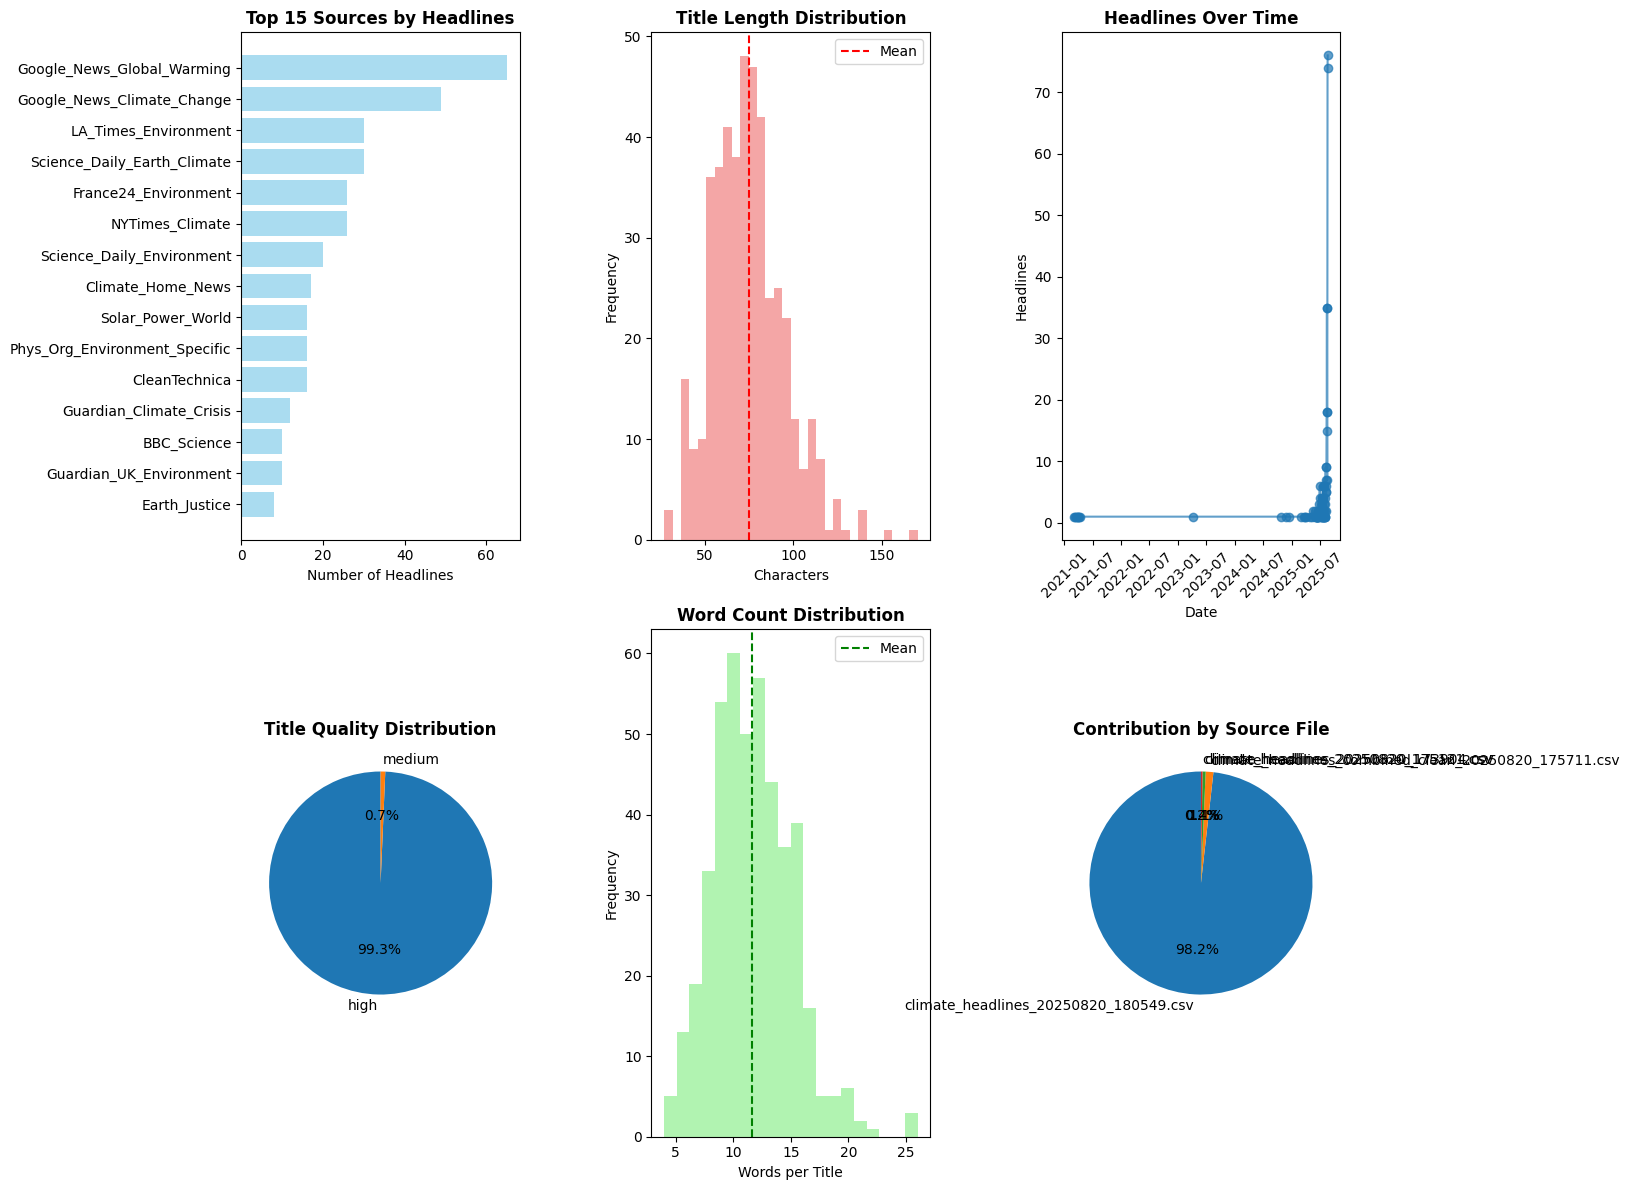

✅ Visualizations created!


In [17]:
if not df_final.empty:
    # Create visualizations
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Headlines by source (top 15)
    plt.subplot(2, 3, 1)
    top_sources = df_final['source'].value_counts().head(15)
    plt.barh(range(len(top_sources)), top_sources.values, color='skyblue', alpha=0.7)
    plt.yticks(range(len(top_sources)), top_sources.index)
    plt.xlabel('Number of Headlines')
    plt.title('Top 15 Sources by Headlines', fontweight='bold')
    plt.gca().invert_yaxis()
    
    # 2. Title length distribution
    plt.subplot(2, 3, 2)
    plt.hist(df_final['title_chars'], bins=30, alpha=0.7, color='lightcoral')
    plt.axvline(df_final['title_chars'].mean(), color='red', linestyle='--', label='Mean')
    plt.xlabel('Characters')
    plt.ylabel('Frequency')
    plt.title('Title Length Distribution', fontweight='bold')
    plt.legend()
    
    # 3. Headlines over time
    plt.subplot(2, 3, 3)
    if df_final['published_date'].notna().any():
        df_with_dates = df_final.dropna(subset=['published_date'])
        df_with_dates['date_only'] = df_with_dates['published_date'].dt.date
        daily_counts = df_with_dates['date_only'].value_counts().sort_index()
        
        plt.plot(daily_counts.index, daily_counts.values, marker='o', alpha=0.7)
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        plt.ylabel('Headlines')
        plt.title('Headlines Over Time', fontweight='bold')
    else:
        plt.text(0.5, 0.5, 'No date\ninformation', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Timeline Not Available', fontweight='bold')
    
    # 4. Quality distribution
    plt.subplot(2, 3, 4)
    quality_counts = df_final['title_quality'].value_counts()
    plt.pie(quality_counts.values, labels=quality_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Title Quality Distribution', fontweight='bold')
    
    # 5. Word count distribution
    plt.subplot(2, 3, 5)
    plt.hist(df_final['title_words'], bins=20, alpha=0.7, color='lightgreen')
    plt.axvline(df_final['title_words'].mean(), color='green', linestyle='--', label='Mean')
    plt.xlabel('Words per Title')
    plt.ylabel('Frequency')
    plt.title('Word Count Distribution', fontweight='bold')
    plt.legend()
    
    # 6. Source file contribution
    plt.subplot(2, 3, 6)
    if 'source_file' in df_final.columns:
        file_counts = df_final['source_file'].value_counts()
        plt.pie(file_counts.values, labels=file_counts.index, autopct='%1.1f%%', startangle=90)
        plt.title('Contribution by Source File', fontweight='bold')
    else:
        plt.text(0.5, 0.5, 'No source file\ninformation', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Source Files Not Available', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualizations created!")

## 8. Save Cleaned Dataset

In [18]:
if not df_final.empty:
    # Create output directory
    output_dir = "../data/processed"
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Define output files
    csv_filename = f"climate_headlines_combined_clean_{timestamp}.csv"
    json_filename = f"climate_headlines_combined_clean_{timestamp}.json"
    metadata_filename = f"climate_headlines_combined_metadata_{timestamp}.json"
    
    csv_path = os.path.join(output_dir, csv_filename)
    json_path = os.path.join(output_dir, json_filename)
    metadata_path = os.path.join(output_dir, metadata_filename)
    
    # Save as CSV
    df_final.to_csv(csv_path, index=False)
    
    # Save as JSON (with datetime handling)
    df_json = df_final.copy()
    for col in df_json.columns:
        if df_json[col].dtype == 'datetime64[ns]':
            df_json[col] = df_json[col].astype(str)
    
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(df_json.to_dict('records'), f, indent=2, ensure_ascii=False)
    
    # Create comprehensive metadata
    metadata = {
        'processing_info': {
            'timestamp': timestamp,
            'source_files': csv_files if 'csv_files' in locals() else [],
            'total_original_rows': total_rows_before if 'total_rows_before' in locals() else 0,
            'final_rows': len(df_final),
            'duplicates_removed': (total_rows_before - len(df_final)) if 'total_rows_before' in locals() else 0,
            'data_retention_rate': len(df_final) / total_rows_before if 'total_rows_before' in locals() and total_rows_before > 0 else 0
        },
        'dataset_characteristics': {
            'total_headlines': len(df_final),
            'unique_sources': df_final['source'].nunique(),
            'unique_urls': df_final['url'].nunique(),
            'date_range': {
                'start': str(df_final['published_date'].min()) if df_final['published_date'].notna().any() else None,
                'end': str(df_final['published_date'].max()) if df_final['published_date'].notna().any() else None,
                'span_days': (df_final['published_date'].max() - df_final['published_date'].min()).days if df_final['published_date'].notna().any() else 0
            },
            'text_statistics': {
                'avg_title_length': float(df_final['title_chars'].mean()),
                'avg_title_words': float(df_final['title_words'].mean()),
                'avg_summary_length': float(df_final['summary_length'].mean())
            }
        },
        'quality_metrics': {
            'headlines_with_summaries': int(df_final['has_summary'].sum()),
            'headlines_with_dates': int(df_final['has_published_date'].sum()),
            'quality_distribution': df_final['title_quality'].value_counts().to_dict()
        },
        'source_distribution': df_final['source'].value_counts().to_dict(),
        'data_schema': {
            'columns': list(df_final.columns),
            'data_types': {col: str(dtype) for col, dtype in df_final.dtypes.items()}
        }
    }
    
    with open(metadata_path, 'w', encoding='utf-8') as f:
        json.dump(metadata, f, indent=2, default=str)
    
    print("💾 DATASET SAVED SUCCESSFULLY!")
    print("=" * 50)
    print(f"📁 CSV file: {csv_path}")
    print(f"📁 JSON file: {json_path}")
    print(f"📁 Metadata: {metadata_path}")
    print(f"📊 Headlines saved: {len(df_final):,}")
    print(f"💾 CSV file size: {os.path.getsize(csv_path) / 1024:.1f} KB")
    print(f"💾 JSON file size: {os.path.getsize(json_path) / 1024:.1f} KB")
    
    # Summary statistics
    print(f"\n📈 FINAL PROCESSING SUMMARY:")
    print("=" * 50)
    if 'total_rows_before' in locals():
        print(f"Original rows: {total_rows_before:,}")
        print(f"Final rows: {len(df_final):,}")
        print(f"Duplicates removed: {total_rows_before - len(df_final):,}")
        print(f"Data retention: {len(df_final)/total_rows_before*100:.1f}%")
    print(f"Unique sources: {df_final['source'].nunique()}")
    print(f"Date coverage: {(df_final['published_date'].max() - df_final['published_date'].min()).days if df_final['published_date'].notna().any() else 0} days")
    print(f"Quality headlines: {(df_final['title_quality'] == 'high').sum():,} ({(df_final['title_quality'] == 'high').mean()*100:.1f}%)")
    
else:
    print("❌ No data to save!")

💾 DATASET SAVED SUCCESSFULLY!
📁 CSV file: ../data/processed\climate_headlines_combined_clean_20250820_180646.csv
📁 JSON file: ../data/processed\climate_headlines_combined_clean_20250820_180646.json
📁 Metadata: ../data/processed\climate_headlines_combined_metadata_20250820_180646.json
📊 Headlines saved: 448
💾 CSV file size: 324.4 KB
💾 JSON file size: 472.3 KB

📈 FINAL PROCESSING SUMMARY:
Original rows: 1,863
Final rows: 448
Duplicates removed: 1,415
Data retention: 24.0%
Unique sources: 39
Date coverage: 1629 days
Quality headlines: 445 (99.3%)


## 9. Summary and Next Steps

### Data Cleaning Process Completed! ✅

This notebook successfully:
1. **Combined multiple CSV files** from the data folder
2. **Removed duplicates** using multiple strategies (exact, URL, title+source, normalized title)
3. **Cleaned missing values** and standardized data types
4. **Added quality metrics** and validation flags
5. **Generated comprehensive analysis** of the final dataset
6. **Saved the cleaned data** in multiple formats with metadata

### Key Improvements Made:
- **Deduplication**: Removed exact duplicates, URL duplicates, and near-duplicate titles
- **Data Quality**: Added quality flags and standardized text fields
- **Type Safety**: Converted all columns to appropriate data types
- **Metadata**: Created comprehensive documentation of the cleaning process

### Files Created:
- `climate_headlines_combined_clean_[timestamp].csv` - Main cleaned dataset
- `climate_headlines_combined_clean_[timestamp].json` - JSON version for structured access
- `climate_headlines_combined_metadata_[timestamp].json` - Complete processing metadata

### Ready for Next Steps:
- ✅ **Emotion Analysis**: Apply GoEmotions model to the cleaned headlines
- ✅ **Cross-Media Comparison**: Compare with climate tweets dataset
- ✅ **Statistical Analysis**: Perform comprehensive emotion pattern analysis
- ✅ **Research Output**: Generate final insights and visualizations

The dataset is now ready for the emotion analysis phase of your climate sentiment research project!